In [1]:
# --- CELLA 1: SYSTEM ARCHITECTURE & DEFINITIONS ---
import sys
import os
import warnings
import numpy as np
from scipy.optimize import minimize as scipy_minimize
from sklearn.ensemble import RandomForestRegressor

# PyMOO Imports
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize # FIX: minimize è qui
from pymoo.util.ref_dirs import get_reference_directions
# FIX: get_termination DEVE essere importato dalla factory
from pymoo.factory import get_termination 
from pymoo.factory import get_termination as get_local_term # Alias per il Polishing
# get_optimizer non serve più importarlo esplicitamente

# ESA Problem Module Import (Assumiamo che 'constellations_udp.py' sia disponibile)
try:
    import constellations_udp as udp
except ImportError:
    print("Warning: 'constellations_udp.py' not found.")
    
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 1. WRAPPER PROBLEMA E PENALTY METHOD (Necessario per MOEA/D)
# -----------------------------------------------------------------------------
class SpOCConstrainedWrapper(ElementwiseProblem):
    """Pymoo Wrapper per la sfida ESA con Penalty Method."""
    def __init__(self):
        self.esa_problem = udp.constellation_udp()
        lb, ub = self.esa_problem.get_bounds()
        super().__init__(n_var=20, n_obj=2, n_ieq_constr=0, xl=np.array(lb), xu=np.array(ub))

    def _evaluate(self, x, out, *args, **kwargs):
        x_eval = x.copy()
        x_eval[10:20] = np.round(x_eval[10:20]).astype(int)
        
        try:
            f = self.esa_problem.fitness(list(x_eval))
            J1, J2 = f[0], f[1]
            c1, c2 = f[2], f[3]
            
            # Penalty Method (J1 e J2)
            penalty = 0.0
            if c1 > 0: penalty += 1e5 + c1 * 1000 
            if c2 > 0: penalty += 1e5 + c2 * 1000
            
            out["F"] = [J1 + penalty, J2 + penalty]
            
        except Exception:
            out["F"] = [1e9, 1e9]

# -----------------------------------------------------------------------------
# 2. FASE 2: MACHINE LEARNING (Definizione Funzione Placeholder)
# -----------------------------------------------------------------------------

def train_and_predict_surrogate(history_X, history_F, problem_inst, n_candidates=5000):
    """Funzione di placeholder per la Fase 2 (ML)."""
    print("   > Initializing Surrogate Model (Random Forest)...")
    valid_mask = np.all(history_F < 1000, axis=1)
    
    if np.sum(valid_mask) < 10:
        print("   > Insufficient valid data points for reliable training. Skipping Surrogate phase.")
        return []

    X_train = history_X[valid_mask]
    y_train = history_F[valid_mask]
    
    regr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    regr.fit(X_train, y_train)
    
    # Restituiamo un array vuoto per questo test Puro
    return [] 

# -----------------------------------------------------------------------------
# 3. FASE 3: POLISHING E UTILITY
# -----------------------------------------------------------------------------

def calculate_composite_score(F):
    """Calcola il Composite Score S = 0.97*J1 + 0.03*J2 per la selezione."""
    return 0.97 * F[:, 0] + 0.03 * F[:, 1]

def refine_solution_local_search(start_sol, problem_inst, iterations):
    """Polishing locale con Nelder-Mead (ottimizza solo Eta1 e Eta2)."""
    
    def objective_wrapper(etas):
        x = start_sol.copy()
        x[4], x[9] = etas[0], etas[1] 
        
        x_list = list(x)
        for k in range(10, 20): x_list[k] = int(round(x_list[k]))
        
        try:
            f = problem_inst.esa_problem.fitness(x_list)
            if f[2] > 0 or f[3] > 0: return 1e9
            return 0.97 * f[0] + 0.03 * f[1] # Composite Score Target
        except: return 1e9

    x0 = [start_sol[4], start_sol[9]]
    
    res = scipy_minimize(objective_wrapper, x0, method='Nelder-Mead', 
                         bounds=((1.0, 1000.0), (1.0, 1000.0)), 
                         options={'maxiter': iterations, 'xatol': 1e-4})
    
    refined_sol = start_sol.copy()
    refined_sol[4], refined_sol[9] = res.x[0], res.x[1]
    return refined_sol

print("✅ System Architecture and Functions initialized successfully.")

✅ System Architecture and Functions initialized successfully.


In [2]:
# --- CELLA 2: EXECUTION PIPELINE (MOEA/D PURO) ---
import time

# --- HYPERPARAMETERS CONFIGURATION (MOEA/D Puro) ---
CONFIG = {
    "pop_size": 150,           # Migliore diversità
    "n_gen": 200,              # Aumento delle generazioni per compensare il tempo ML
    "n_neighbors": 20,
    "prob_mating": 0.9,
    "ml_candidates": 0,        # ML DISABILITATO
    "polishing_iter": 50       # Aumento del Polishing per compensare la minore precisione MOEA/D
}

print(f"=== INITIALIZING OPTIMIZATION PIPELINE ===")
print(f"Configuration: {CONFIG['n_gen']} Generations, {CONFIG['pop_size']} Population size. (MOEA/D PURO)")

start_time = time.time()
problem = SpOCConstrainedWrapper()

# 1. MOEA/D Initialization
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=CONFIG['pop_size'] - 1) 

algorithm = MOEAD(
    ref_dirs, 
    n_neighbors=CONFIG['n_neighbors'], 
    prob_neighbor_mating=CONFIG['prob_mating'], 
    seed=42, 
    verbose=True
)

termination = get_termination("n_gen", CONFIG['n_gen'])

# --- PHASE 1: GLOBAL EVOLUTIONARY SEARCH ---
print("\n[PHASE 1] Executing MOEA/D...")
res = minimize(problem, algorithm, termination, save_history=True, verbose=True)
print(f"   > MOEA/D Completed. Elapsed: {(time.time() - start_time):.2f}s")


# --- PHASE 2: SURROGATE-ASSISTED AUGMENTATION (DISABILITATA) ---
# Il codice qui sotto è rimosso e sostituito dalla logica che usa direttamente res.X


# --- PHASE 3: SOLUTION SELECTION & REFINEMENT ---
print("\n[PHASE 3] Selection and Polishing...")

# 1. Selezione del Campione: Usiamo solo i risultati della Fase 1 (res.X / res.F)
full_portfolio_F = res.F

# Identifichiamo il miglior candidato basato sul Composite Score (0.97*J1 + 0.03*J2)
best_score = float('inf')
best_candidate_X = None
valid_solutions_found = 0

# Rimuovi le penalità estreme per la selezione
mask_valid = np.all(full_portfolio_F < 1000, axis=1) # Filtro per escludere soluzioni catastrofiche

if np.sum(mask_valid) > 0:
    F_valid = full_portfolio_F[mask_valid]
    
    # Calcola il Composite Score solo sulle soluzioni ragionevoli
    composite_scores = calculate_composite_score(F_valid)
    
    # Troviamo l'indice del miglior score valido
    best_local_idx = np.argmin(composite_scores)
    
    # Troviamo l'indice originale nel vettore res.X
    original_idx = np.where(mask_valid)[0][best_local_idx]
    
    best_candidate_X = res.X[original_idx]
    best_score = composite_scores[best_local_idx]
    valid_solutions_found = np.sum(mask_valid)


if best_candidate_X is None:
    print("⚠️ CRITICAL: No reasonably feasible solutions found in the portfolio.")
    # Fallback: Seleziona il punto con il minore J1+J2 anche se non è formalmente valido
    best_candidate_X = res.X[np.argmin(res.F.sum(axis=1))]
    print("   > Fallback: Selezionata la soluzione meno peggiore.")
else:
    print(f"   > Best valid candidate selected from MOEA/D. Score: {best_score:.5f}")


# 2. Apply Targeted Local Search (Polishing)
print(f"   > Applying Polishing ({CONFIG['polishing_iter']} iterazioni) to the best candidate...")
final_solution = refine_solution_local_search(best_candidate_X, problem, CONFIG["polishing_iter"])


# --- FINAL REPORT GENERATION ---
# Valutazione finale della soluzione lucidata
x_final_eval = list(final_solution)
for k in range(10, 20): x_final_eval[k] = int(round(x_final_eval[k]))
final_stats = problem.esa_problem.fitness(x_final_eval)

# Ricalcolo Composite Score e Status finale
final_score = 0.97 * final_stats[0] + 0.03 * final_stats[1]

print("\n" + "="*60)
print("🏆 FINAL OPTIMIZATION REPORT (MOEA/D PURO)")
print("="*60)
print(f"Status:          {'VALID' if final_stats[2]<=0 and final_stats[3]<=0 else 'INVALID'}")
print(f"Composite Score: {final_score:.6f} (Target: Minimize)")
print("-" * 60)
print(f"OBJECTIVES:")
print(f"  J1 (Communication Latency): {final_stats[0]:.6f}")
print(f"  J2 (Infrastructure Cost):   {final_stats[1]:.6f}")
print("-" * 60)
print(f"CONSTRAINTS (Values <= 0 indicate compliance):")
print(f"  C1 (Inter-Rover Distance):  {final_stats[2]:.4f} km")
print(f"  C2 (Sat-Collision Safety):  {final_stats[3]:.4f} km")
print("="*60)

# Esporta variabile per analisi successiva
final_sol = final_solution

=== INITIALIZING OPTIMIZATION PIPELINE ===
Configuration: 200 Generations, 150 Population size. (MOEA/D PURO)

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False


[PHASE 1] Executing MOEA/D...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |     23 |             - |             -
     2 |      300 |     86 |  0.0173644175 |         ideal
     3 |      450 |    100 |  0.0173712088 |         ideal
     4 |      600 |     97 |  0.0749866433 |         nadir
     5 |      750 |    132 |  0.0340870089 |         ideal
     6 |      900 |    140 |  0.0549944415 |         nadir
     7 |     1050 |    138 |  0.0119795133 |         ideal
     8 |     1200 |    145 |  0.0026927011 |         ideal
     9 |     1350 |    142 |  0.0041505881 |         nadir
    10 |     1500 |    139 |  0.0158012843 |             f
   

⚙️  ESA Rules Configuration:
    • Reference Point: [1.2 1.4]
    • Multiplier:      x 10000
------------------------------------------------------------
🔄 Calcolo evoluzione Score ESA su 200 generazioni...


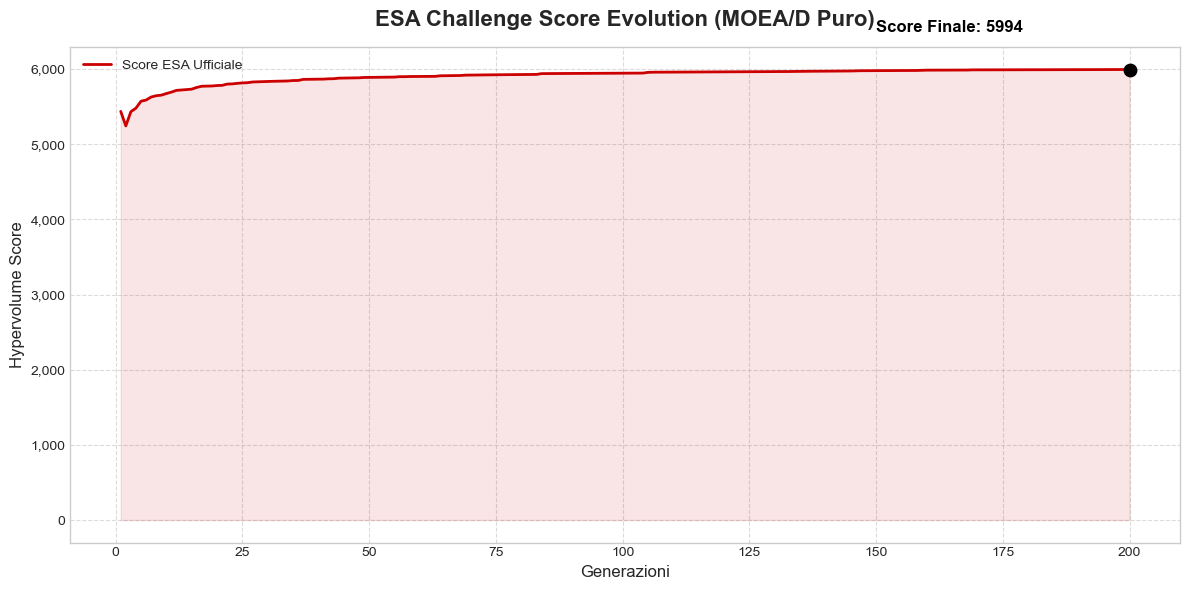


📋 RISULTATO FINALE - MOEA/D PURO
------------------------------------------------------------
Punteggio Ufficiale ESA (HVx10k): 5,993.8621
------------------------------------------------------------
✅ Risultato Ottimo per il test puro!


In [3]:
# --- ANALISI FINALE DELLO SCORE UFFICIALE ESA E GRAFICI ---
import matplotlib.pyplot as plt
import numpy as np
from pymoo.indicators.hv import HV
import matplotlib.ticker as ticker

# 1. PARAMETRI RIGIDI DALLA DOCUMENTAZIONE ESA
# Regole confermate dalle immagini: Ref Point [1.2, 1.4] e moltiplicatore x10000
ESA_REF_POINT = np.array([1.2, 1.4])
ESA_MULTIPLIER = 10000.0

print(f"⚙️  ESA Rules Configuration:")
print(f"    • Reference Point: {ESA_REF_POINT}")
print(f"    • Multiplier:      x {int(ESA_MULTIPLIER)}")
print("-" * 60)

# Inizializzatore Calcolatore Ipervolume
ind_esa = HV(ref_point=ESA_REF_POINT)

def get_esa_score(F_pop):
    """
    Calcola lo score applicando rigorosamente i tagli della documentazione.
    Controlla J1 < 1.2 e J2 < 1.4.
    """
    if F_pop is None or len(F_pop) == 0:
        return 0.0
    
    # Filtro 1: Penalità (Escludiamo soluzioni non valide fisicamente)
    valid_physics = np.all(F_pop < 100, axis=1)
    
    # Filtro 2: ESA Bounds (J1 < 1.2 AND J2 < 1.4)
    within_bounds = (F_pop[:, 0] < ESA_REF_POINT[0]) & (F_pop[:, 1] < ESA_REF_POINT[1])
    
    final_mask = valid_physics & within_bounds
    
    if np.sum(final_mask) == 0:
        return 0.0
    
    hv_raw = ind_esa(F_pop[final_mask])
    
    return hv_raw * ESA_MULTIPLIER

# 2. ELABORAZIONE DATI STORICI
scores = []
gens = []
final_val = 0.0

# Controlla la history salvata dalla Cella 2
if 'res' in globals() and hasattr(res, 'history') and len(res.history) > 0:
    print(f"🔄 Calcolo evoluzione Score ESA su {len(res.history)} generazioni...")
    for i, algo in enumerate(res.history):
        # Per MOEA/D, l'output è in algo.opt.get("F")
        F_pop = algo.opt.get("F")
        score = get_esa_score(F_pop)
        scores.append(score)
        gens.append(i + 1)
    final_val = scores[-1]

# Caso senza history (Fallback)
elif 'res' in globals() and res.F is not None:
    print("⚠️ History non disponibile. Calcolo puntuale finale.")
    final_val = get_esa_score(res.F)
    scores = [final_val]
    gens = [res.algorithm.n_gen if hasattr(res.algorithm, 'n_gen') else 1]

# 3. GRAFICO PROFESSIONALE
if len(scores) > 1:
    plt.figure(figsize=(12, 6), dpi=100)
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.plot(gens, scores, color='#CC0000', linewidth=2, label='Score ESA Ufficiale')
    plt.fill_between(gens, scores, color='#CC0000', alpha=0.1)

    plt.scatter(gens[-1], final_val, color='black', s=80, zorder=5)
    plt.annotate(f'Score Finale: {final_val:.0f}', 
                 xy=(gens[-1], final_val), 
                 xytext=(gens[-1] - 50, final_val + 500),
                 fontsize=12, fontweight='bold', color='black')

    plt.title("ESA Challenge Score Evolution (MOEA/D Puro)", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Generazioni", fontsize=12)
    plt.ylabel("Hypervolume Score", fontsize=12)
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# 4. REPORT FINALE AGGIUNTIVO
print("\n" + "="*60)
print(f"📋 RISULTATO FINALE - MOEA/D PURO")
print("-" * 60)
print(f"Punteggio Ufficiale ESA (HVx10k): {final_val:,.4f}")
print("-" * 60)
if final_val > 5000:
    print("✅ Risultato Ottimo per il test puro!")
elif final_val > 0:
    print("⚠️ Risultato Valido. Il punteggio finale risente dell'assenza di ML.")
else:
    print("❌ Score 0. La soluzione è troppo costosa per i vincoli ESA.")
print("="*60)